In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, sobel

# from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def apply_gaussian_filter(image, sigma):

    # Calculate kernel size (odd and at least 3x3)
    ksize = int(6 * sigma + 1)
    if ksize % 2 == 0:
        ksize += 1

    # Create 2D Gaussian kernel
    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernal= kernel / np.sum(kernel)  # Normalize the kernel

    # kernel_2d = np.array([[1, 2, 1],
    #                  [2, 4, 2],
    #                  [1, 2, 1]], dtype=np.float32) / 16

    # Apply filter using convolution
    filtered = cv2.filter2D(image, -1, kernal)

    return filtered


In [4]:

def bilaterals_filter(image, sigma_s, sigma_r):
    image = image.astype(np.float32)
    ksize = int(6 * sigma_s + 1) | 1  # Ensure odd kernel size
    half_ksize = ksize // 2

    # Create spatial kernel
    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    x, y = np.meshgrid(ax, ax)
    spatial_kernel = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    # Pad image to handle borders
    padded = cv2.copyMakeBorder(image, half_ksize, half_ksize, half_ksize, half_ksize, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(image)

    # Apply filter
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+ksize, j:j+ksize]
            range_kernel = np.exp(-((region - image[i, j])**2) / (2 * sigma_r**2))
            kernel = spatial_kernel * range_kernel
            kernel /= kernel.sum()
            filtered[i, j] = (region * kernel).sum()

    return filtered.astype(np.uint8)


def bilateral_filter(image, sigma_s, sigma_r):

    # Convert sigma_r to OpenCV scale (0-255 intensity range)
    sigma_r_scaled = sigma_r * 255  
    filtered = cv2.bilateralFilter(image, d=0, sigmaColor=sigma_r_scaled, sigmaSpace=sigma_s)
    return filtered

In [5]:

def roberts_operator(image):

    image = image.astype(np.float32)/255.0
    kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
    kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
    grad_x = cv2.filter2D(image, -1, kernel_x)
    grad_y = cv2.filter2D(image, -1, kernel_y)
    gradient = np.sqrt(grad_x**2 + grad_y**2)
    gradient = (gradient / gradient.max()) * 255
    gradient[gradient > 255] = 255  # Ensure values do not exceed 255
    gradient[gradient < 0] = 0      # Ensure values are not below 0

    return gradient.astype(np.uint8)

In [6]:
# def canny_operator(image, low_threshold=34, high_threshold=100):
#     """Apply Canny edge detection operator"""
#     return cv2.Canny(image, low_threshold, high_threshold)

import numpy as np
from scipy.ndimage import gaussian_filter, sobel

def canny_operator1(image, low_threshold=10, high_threshold=80):

    #Step 1: Noise Reduction using Gaussian filter
    smoothed_image = gaussian_filter(image, sigma=1.4)

    # Step 2: Gradient Calculation using Sobel filters
    gradient_x = sobel(image, axis=0)
    gradient_y = sobel(image, axis=1)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Step 3: Non-Maximum Suppression
    def non_maximum_suppression(magnitude, direction):
        suppressed = np.zeros_like(magnitude)
        angle = direction % 180  # Normalize angles to [0, 180]

        rows, cols = magnitude.shape
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                q, r = 0, 0

                # Determine neighbors based on gradient direction
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j + 1]
                    r = magnitude[i, j - 1]
                elif (22.5 <= angle[i, j] < 67.5):
                    q = magnitude[i + 1, j - 1]
                    r = magnitude[i - 1, j + 1]
                elif (67.5 <= angle[i, j] < 112.5):
                    q = magnitude[i + 1, j]
                    r = magnitude[i - 1, j]
                elif (112.5 <= angle[i, j] < 157.5):
                    q = magnitude[i - 1, j - 1]
                    r = magnitude[i + 1, j + 1]

                # Suppress non-maximum values
                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    suppressed[i, j] = magnitude[i, j]

        return suppressed

    suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

    # Step 4: Double Thresholding
    strong_edges = suppressed_image >= high_threshold
    weak_edges = (suppressed_image >= low_threshold) & ~strong_edges

    # Step 5: Edge Tracking by Hysteresis
    def hysteresis_tracking(strong_edges, weak_edges):
        edges = np.copy(strong_edges)
        rows, cols = edges.shape

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if weak_edges[i, j]:
                    # Check if connected to strong edges
                    if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                        edges[i, j] = True

        return edges

    final_edges = hysteresis_tracking(strong_edges.astype(bool), weak_edges.astype(bool))

    return final_edges.astype(np.uint8) * 255

In [7]:
def canny_operator(
    image,
    low_threshold=34,
    high_threshold=68,
    kernel_size=2,
    use_gaussian_blur=True,
    blur_kernel_size=5,
    blur_sigma=1.4,
    use_auto_thresholds=False,
    auto_threshold_ratio=.8,
    l2_gradient=False
):

    # Validate kernel sizes
    if kernel_size % 2 == 0:
        kernel_size += 1
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1

    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur if enabled
    if use_gaussian_blur:
        image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), blur_sigma)

    # Calculate automatic thresholds if enabled
    if use_auto_thresholds:
        median_val = np.median(image)
        high_threshold = min(255, int(max(0, median_val * (1.0 + auto_threshold_ratio))))
        low_threshold = max(0, int(high_threshold * 0.5))

    # Apply Canny edge detection
    edges = cv2.Canny(
        image=image,
        threshold1=low_threshold,
        threshold2=high_threshold,
        apertureSize=kernel_size,
        L2gradient=l2_gradient
    )

    return edges

In [8]:

def frei_chen_operator(image):

    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Normalize
    image = image.astype(np.float32)/255.0

    # Kernels
    sqrt2 = np.sqrt(2)
    g1 = np.array([[1, sqrt2, 1], [0,0,0], [-1,-sqrt2,-1]])/(2+2*sqrt2)
    g2 = np.array([[1,0,-1], [sqrt2,0,-sqrt2], [1,0,-1]])/(2+2*sqrt2)

    # Convolve
    grad1 = cv2.filter2D(image, -1, g1)
    grad2 = cv2.filter2D(image, -1, g2)

    # Magnitude
    grad_mag = np.sqrt(grad1**2 + grad2**2)
    grad_mag = (grad_mag/grad_mag.max() * 255).astype(np.uint8)

    # Auto-thresholding
    high_thresh = max(30, grad_mag.max() * 0.2)
    low_thresh = high_thresh * 0.5
    edges = np.zeros_like(grad_mag)
    edges[grad_mag > high_thresh] = 255
    #edges[(grad_mag >= low_thresh) & (grad_mag <= high_thresh)] = 128
    edges[grad_mag < low_thresh] = 0

    return edges

In [9]:
def mean_squared_error(original, processed):

    # Ensure inputs are numpy arrays and have same shape
    original = np.asarray(original)
    processed = np.asarray(processed)

    if original.shape != processed.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert to float64 to prevent overflow
    original = original.astype(np.float64)
    processed = processed.astype(np.float64)

    # Calculate MSE
    mse = np.mean((original - processed) ** 2)

    return mse

def peak_signal_noise_ratio(original, processed, data_range=255):

    # Calculate MSE first
    mse = mean_squared_error(original, processed)

    # Handle case where MSE is zero (perfect match)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    psnr = 10 * np.log10((data_range ** 2) / mse)

    return psnr
    
from skimage.metrics import structural_similarity

def compute_ssim(original, processed):
    return structural_similarity(original, processed, data_range=original.max() - original.min())

In [10]:
def sharpen_image_with_edges(original, edge_map, alpha=2):
    # Ensure both are float32 for processing
    original = original.astype(np.float32)
    edge_map = edge_map.astype(np.float32)

    # Normalize edge map to [0, 1]
    edge_map /= 255.0

    # Sharpen: original + alpha * edge
    sharpened = original + alpha * edge_map * original

    # Clip and convert back to uint8
    sharpened = np.clip(sharpened, 0, 255)
    return sharpened.astype(np.uint8)



def evaluate_results(original, processed):
    mse = mean_squared_error(original, processed)
    psnr = peak_signal_noise_ratio(original, processed, data_range=255)
    ssim = compute_ssim(original, processed)
    return mse, psnr ,ssim

def process_image(image_path, sigma_gaussian, sigma_s, sigma_r):

    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or couldn't be loaded")

    # Resize to 300x300 as in the paper
    image = cv2.resize(image, (300, 300))

    # Apply Gaussian filter
    gaussian_filtered = apply_gaussian_filter(image, sigma_gaussian)

    # Apply Bilateral filter
    bilateral_filtered = bilateral_filter(image, sigma_s, sigma_r)

    # Edge detection on Gaussian filtered image
    roberts_gaussian = roberts_operator(gaussian_filtered)
    canny_gaussian = canny_operator(gaussian_filtered)
    frei_chen_gaussian = frei_chen_operator(gaussian_filtered)

    # Edge detection on Bilateral filtered image
    roberts_bilateral = roberts_operator(bilateral_filtered)
    canny_bilateral = canny_operator(bilateral_filtered)
    frei_chen_bilateral = frei_chen_operator(bilateral_filtered)

    # Evaluate results
    results = {
        'Gaussian Filter': {
            'Canny': evaluate_results(image, roberts_gaussian),
            'Frei-Chen': evaluate_results(image, canny_gaussian),
            'Roberts': evaluate_results(image, frei_chen_gaussian)
        },
        'Bilateral Filter': {
            'Canny': evaluate_results(image, roberts_bilateral),
            'Frei-Chen': evaluate_results(image, canny_bilateral),
            'Roberts': evaluate_results(image, frei_chen_bilateral)
        }
    }
    # Sharpen filtered images using their respective edge maps
    sharpened_gaussian_roberts = sharpen_image_with_edges(gaussian_filtered, roberts_gaussian)
    sharpened_gaussian_canny = sharpen_image_with_edges(gaussian_filtered, canny_gaussian)
    sharpened_gaussian_frei_chen = sharpen_image_with_edges(gaussian_filtered, frei_chen_gaussian)

    sharpened_bilateral_roberts = sharpen_image_with_edges(bilateral_filtered, roberts_bilateral)
    sharpened_bilateral_canny = sharpen_image_with_edges(bilateral_filtered, canny_bilateral)
    sharpened_bilateral_frei_chen = sharpen_image_with_edges(bilateral_filtered, frei_chen_bilateral)

    # Evaluate sharpened images against the original image
    sharpened_results = {
        'Sharpened image (Gaussian + Canny)': evaluate_results(image, sharpened_gaussian_roberts),
        'Sharpened image(Gaussian + Roberts)': evaluate_results(image, sharpened_gaussian_canny),
        'Sharpened image(Gaussian + Frei-Chen)': evaluate_results(image, sharpened_gaussian_frei_chen),
        'Sharpened image(Bilateral + Canny': evaluate_results(image, sharpened_bilateral_roberts),
        'Sharpened image(Bilateral + Roberts)': evaluate_results(image, sharpened_bilateral_canny),
        'Sharpened image(Bilateral + Frei-Chen)': evaluate_results(image, sharpened_bilateral_frei_chen),
    }

    results['Sharpened with Edges'] = sharpened_results


    # Display results
    plt.figure(figsize=(15, 10))

    # Original and filtered images
    plt.subplot(3, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(3, 3, 2)
    plt.imshow(gaussian_filtered, cmap='gray')
    plt.title(f'Gaussian Filter\nσ={sigma_gaussian}')
    plt.axis('off')

    plt.subplot(3, 3, 3)
    plt.imshow(bilateral_filtered, cmap='gray')
    plt.title(f'Bilateral Filter\nσ_s={sigma_s}, σ_r={sigma_r}')
    plt.axis('off')

    # Gaussian filter edge detection
    plt.subplot(3, 3, 4)
    plt.imshow(roberts_gaussian, cmap='gray')
    plt.title('Roberts (Gaussian)')
    plt.axis('off')

    plt.subplot(3, 3, 5)
    plt.imshow(canny_gaussian, cmap='gray')
    plt.title('Canny (Gaussian)')
    plt.axis('off')

    plt.subplot(3, 3, 6)
    plt.imshow(frei_chen_gaussian, cmap='gray')
    plt.title('Frei-Chen (Gaussian)')
    plt.axis('off')

    # Bilateral filter edge detection
    plt.subplot(3, 3, 7)
    plt.imshow(roberts_bilateral, cmap='gray')
    plt.title('Roberts (Bilateral)')
    plt.axis('off')

    plt.subplot(3, 3, 8)
    plt.imshow(canny_bilateral, cmap='gray')
    plt.title('Canny (Bilateral)')
    plt.axis('off')

    plt.subplot(3, 3, 9)
    plt.imshow(frei_chen_bilateral, cmap='gray')
    plt.title('Frei-Chen (Bilateral)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 6))
    titles = [
        'G+Roberts', 'G+Canny', 'G+Frei-Chen',
        'B+Roberts', 'B+Canny', 'B+Frei-Chen'
    ]
    images = [
        sharpened_gaussian_roberts, sharpened_gaussian_canny, sharpened_gaussian_frei_chen,
        sharpened_bilateral_roberts, sharpened_bilateral_canny, sharpened_bilateral_frei_chen
    ]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Sharpened: {title}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



    return results


# def process_image(image_path, sigma_gaussian, sigma_s, sigma_r):
#     # Load image
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     if image is None:
#         raise ValueError("Image not found or couldn't be loaded")

#     # Resize to 300x300 as in the paper
#     image = cv2.resize(image, (300, 300))

#     # Apply Gaussian filter
#     gaussian_filtered = apply_gaussian_filter(image, sigma_gaussian)

#     # Apply Bilateral filter
#     bilateral_filtered = bilateral_filter(image, sigma_s, sigma_r)

#     # Edge detection on Gaussian filtered image
#     roberts_gaussian = roberts_operator(gaussian_filtered)
#     canny_gaussian = canny_operator(gaussian_filtered)
#     frei_chen_gaussian = frei_chen_operator(gaussian_filtered)

#     # Edge detection on Bilateral filtered image
#     roberts_bilateral = roberts_operator(bilateral_filtered)
#     canny_bilateral = canny_operator(bilateral_filtered)
#     frei_chen_bilateral = frei_chen_operator(bilateral_filtered)

#     # Overlay edges on the original image
#     def overlay_edges(original, edges, color=(255, 0, 0)):
#         # Convert original to color (if grayscale)
#         if len(original.shape) == 2:
#             original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
#         # Create a colored edge mask
#         edge_mask = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
#         edge_mask[np.where((edge_mask == [255, 255, 255]).all(axis=2))] = color
#         # Overlay edges
#         overlayed = cv2.addWeighted(original, 0.7, edge_mask, 0.3, 0)
#         return overlayed

#     # Create overlayed images
#     overlayed_roberts_gaussian = overlay_edges(image, roberts_gaussian, (255, 0, 0))  # Red
#     overlayed_canny_gaussian = overlay_edges(image, canny_gaussian, (0, 255, 0))      # Green
#     overlayed_frei_chen_gaussian = overlay_edges(image, frei_chen_gaussian, (0, 0, 255))  # Blue

#     overlayed_roberts_bilateral = overlay_edges(image, roberts_bilateral, (255, 0, 0))
#     overlayed_canny_bilateral = overlay_edges(image, canny_bilateral, (0, 255, 0))
#     overlayed_frei_chen_bilateral = overlay_edges(image, frei_chen_bilateral, (0, 0, 255))

#     # Display results
#     plt.figure(figsize=(15, 15))

#     # Original and filtered images
#     plt.subplot(3, 3, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title('Original Image')
#     plt.axis('off')

#     plt.subplot(3, 3, 2)
#     plt.imshow(gaussian_filtered, cmap='gray')
#     plt.title(f'Gaussian Filter\nσ={sigma_gaussian}')
#     plt.axis('off')

#     plt.subplot(3, 3, 3)
#     plt.imshow(bilateral_filtered, cmap='gray')
#     plt.title(f'Bilateral Filter\nσ_s={sigma_s}, σ_r={sigma_r}')
#     plt.axis('off')

#     # Gaussian filter edge detection overlays
#     plt.subplot(3, 3, 4)
#     plt.imshow(overlayed_roberts_gaussian)
#     plt.title('Roberts (Gaussian) Overlay')
#     plt.axis('off')

#     plt.subplot(3, 3, 5)
#     plt.imshow(overlayed_canny_gaussian)
#     plt.title('Canny (Gaussian) Overlay')
#     plt.axis('off')

#     plt.subplot(3, 3, 6)
#     plt.imshow(overlayed_frei_chen_gaussian)
#     plt.title('Frei-Chen (Gaussian) Overlay')
#     plt.axis('off')

#     # Bilateral filter edge detection overlays
#     plt.subplot(3, 3, 7)
#     plt.imshow(overlayed_roberts_bilateral)
#     plt.title('Roberts (Bilateral) Overlay')
#     plt.axis('off')

#     plt.subplot(3, 3, 8)
#     plt.imshow(overlayed_canny_bilateral)
#     plt.title('Canny (Bilateral) Overlay')
#     plt.axis('off')

#     plt.subplot(3, 3, 9)
#     plt.imshow(overlayed_frei_chen_bilateral)
#     plt.title('Frei-Chen (Bilateral) Overlay')
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

#     return {
#         'Gaussian Filter': {
#             'Roberts': evaluate_results(image, roberts_gaussian),
#             'Canny': evaluate_results(image, canny_gaussian),
#             'Frei-Chen': evaluate_results(image, frei_chen_gaussian)
#         },
#         'Bilateral Filter': {
#             'Roberts': evaluate_results(image, roberts_bilateral),
#             'Canny': evaluate_results(image, canny_bilateral),
#             'Frei-Chen': evaluate_results(image, frei_chen_bilateral)
#         }
#     }




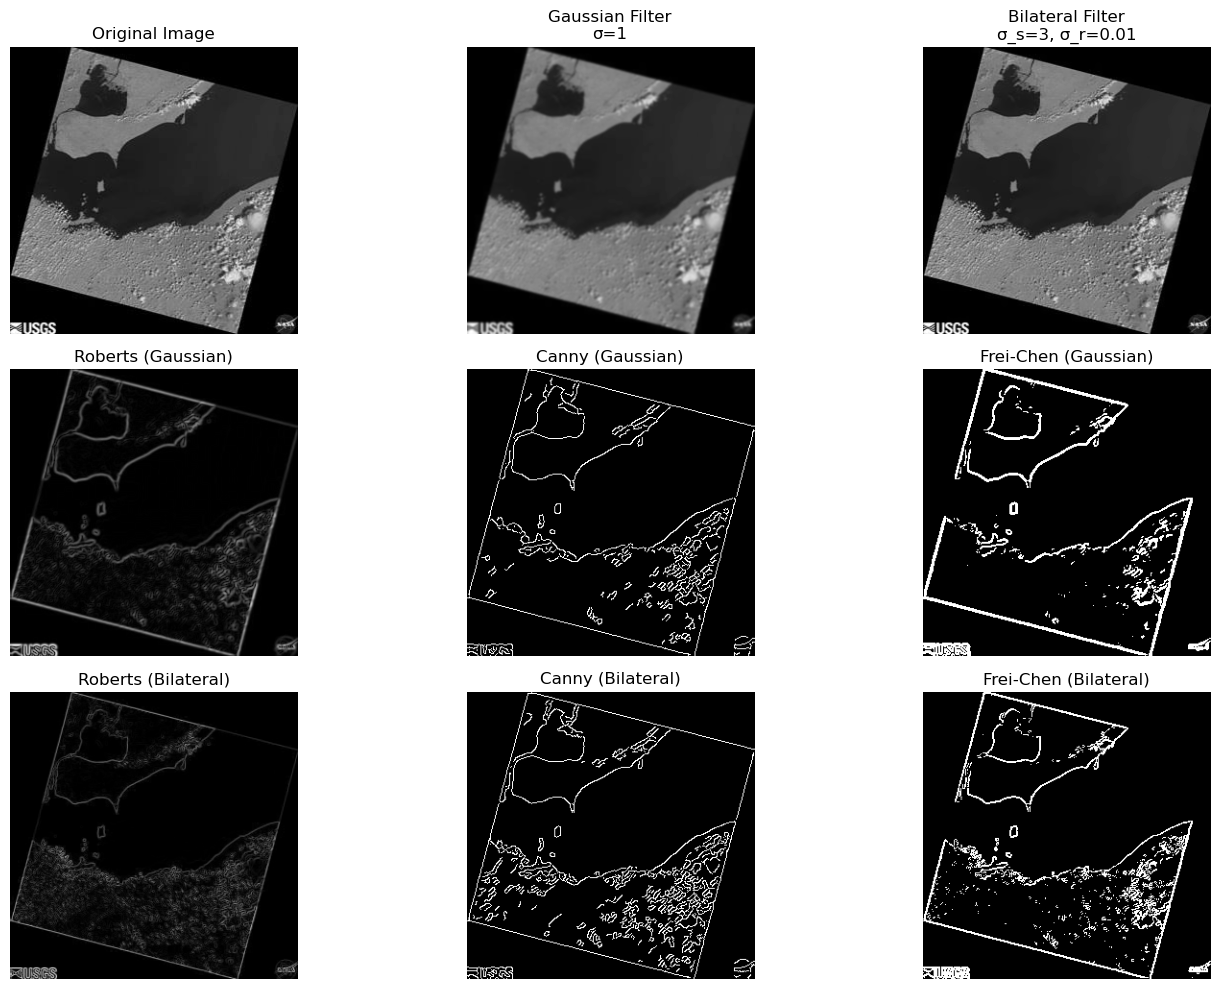

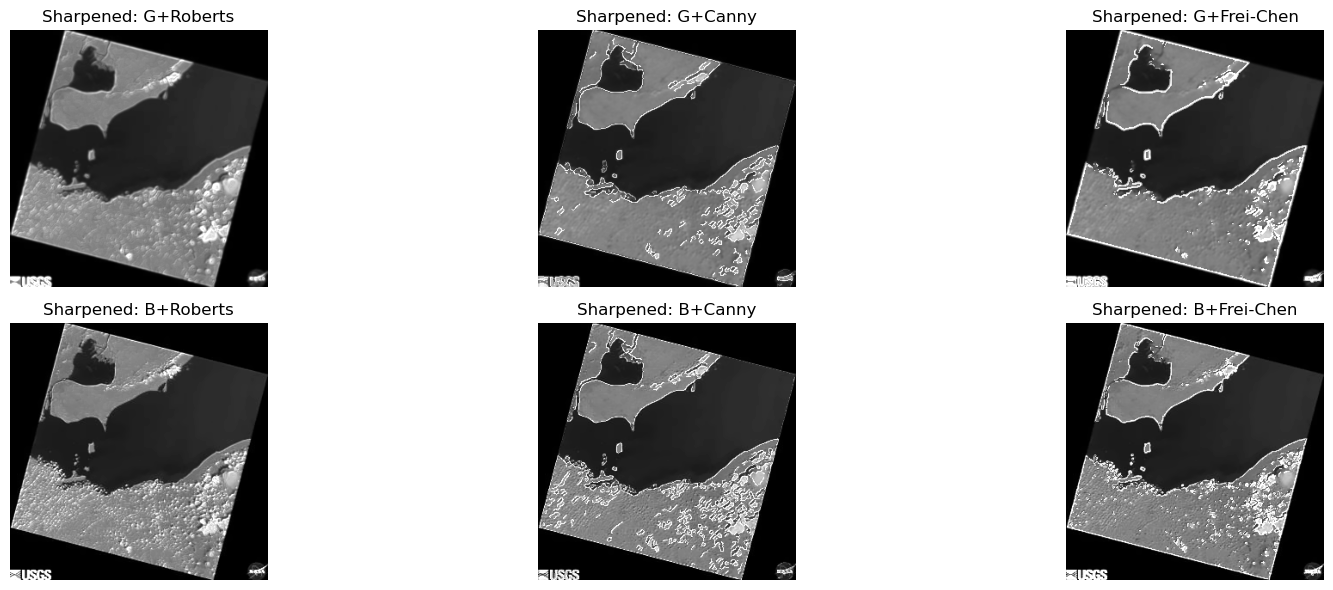


Evaluation Results:

Gaussian Filter:
Canny: MSE = 5254.2408, PSNR = 10.9257 dB, SSIM = 0.2896
Frei-Chen: MSE = 7662.3323, PSNR = 9.2872 dB, SSIM = 0.2516
Roberts: MSE = 8336.5693, PSNR = 8.9209 dB, SSIM = 0.2411

Bilateral Filter:
Canny: MSE = 5145.1357, PSNR = 11.0168 dB, SSIM = 0.3049
Frei-Chen: MSE = 7664.5989, PSNR = 9.2859 dB, SSIM = 0.2537
Roberts: MSE = 7894.0734, PSNR = 9.1578 dB, SSIM = 0.2518

Sharpened with Edges:
Sharpened image (Gaussian + Canny): MSE = 393.7833, PSNR = 22.1782 dB, SSIM = 0.8312
Sharpened image(Gaussian + Roberts): MSE = 956.3857, PSNR = 18.3245 dB, SSIM = 0.7122
Sharpened image(Gaussian + Frei-Chen): MSE = 1222.7817, PSNR = 17.2573 dB, SSIM = 0.7288
Sharpened image(Bilateral + Canny: MSE = 296.5704, PSNR = 23.4095 dB, SSIM = 0.9214
Sharpened image(Bilateral + Roberts): MSE = 1060.8771, PSNR = 17.8742 dB, SSIM = 0.7639
Sharpened image(Bilateral + Frei-Chen): MSE = 1025.3032, PSNR = 18.0223 dB, SSIM = 0.8040


In [11]:
# Example usage 3
if __name__ == "__main__":
    #satellite image path
    image_path = "C:\\Users\\2001a\\Downloads\\DIP project\\15.jpg"

    # Parameters from the paper
    sigma_gaussian = 1 # Standard deviation for Gaussian filter
    sigma_s = 3        # Spatial parameter for Bilateral filter
    sigma_r = 0.01        # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr ,ssim = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.4f}, PSNR = {psnr:.4f} dB, SSIM = {ssim:.4f}")

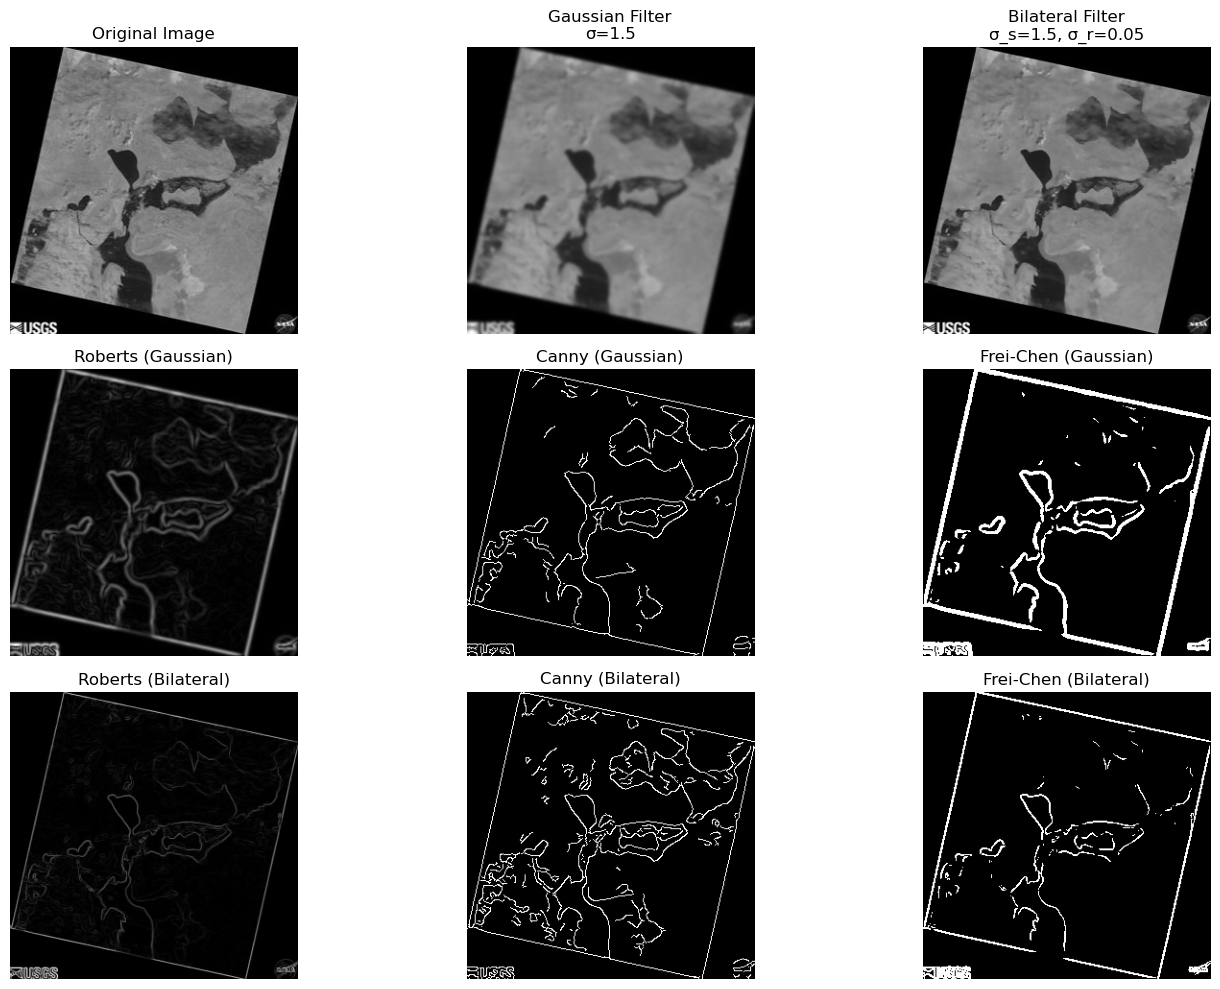

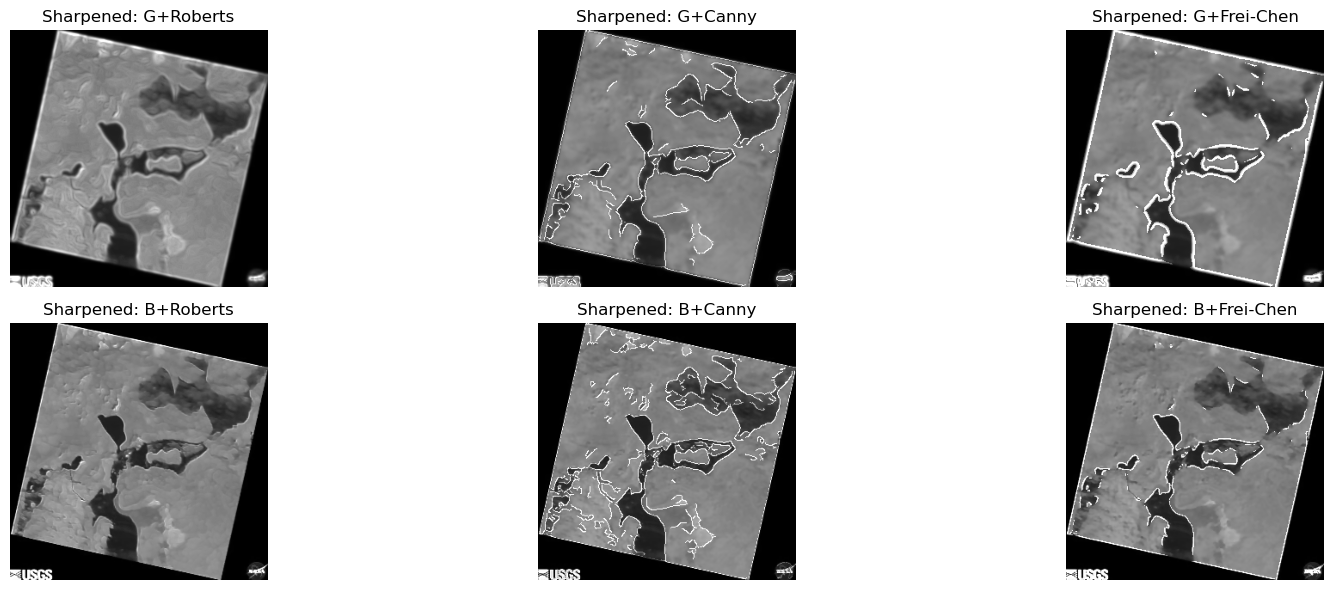


Evaluation Results:

Gaussian Filter:
Canny: MSE = 8451.9612, PSNR = 8.8612 dB, SSIM = 0.2337
Frei-Chen: MSE = 11272.9338, PSNR = 7.6104 dB, SSIM = 0.2149
Roberts: MSE = 12802.1858, PSNR = 7.0580 dB, SSIM = 0.1905

Bilateral Filter:
Canny: MSE = 9487.2608, PSNR = 8.3594 dB, SSIM = 0.2481
Frei-Chen: MSE = 11382.0795, PSNR = 7.5686 dB, SSIM = 0.2164
Roberts: MSE = 11542.0268, PSNR = 7.5080 dB, SSIM = 0.2071

Sharpened with Edges:
Sharpened image (Gaussian + Canny): MSE = 474.4207, PSNR = 21.3692 dB, SSIM = 0.7581
Sharpened image(Gaussian + Roberts): MSE = 1011.1158, PSNR = 18.0828 dB, SSIM = 0.6717
Sharpened image(Gaussian + Frei-Chen): MSE = 1632.3905, PSNR = 16.0026 dB, SSIM = 0.7029
Sharpened image(Bilateral + Canny: MSE = 145.7553, PSNR = 26.4946 dB, SSIM = 0.9145
Sharpened image(Bilateral + Roberts): MSE = 1075.2073, PSNR = 17.8159 dB, SSIM = 0.6862
Sharpened image(Bilateral + Frei-Chen): MSE = 686.1404, PSNR = 19.7667 dB, SSIM = 0.8380


In [12]:
# Example usage 1
if __name__ == "__main__":
    #satellite image path
    image_path = "C:\\Users\\2001a\\Downloads\\DIP project\\7.jpg"

    
    # Parameters from the paper
    sigma_gaussian = 1.5  # Standard deviation for Gaussian filter
    sigma_s = 1.5         # Spatial parameter for Bilateral filter
    sigma_r = 0.05        # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr,ssim = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.4f}, PSNR = {psnr:.4f} dB, SSIM = {ssim:.4f}")

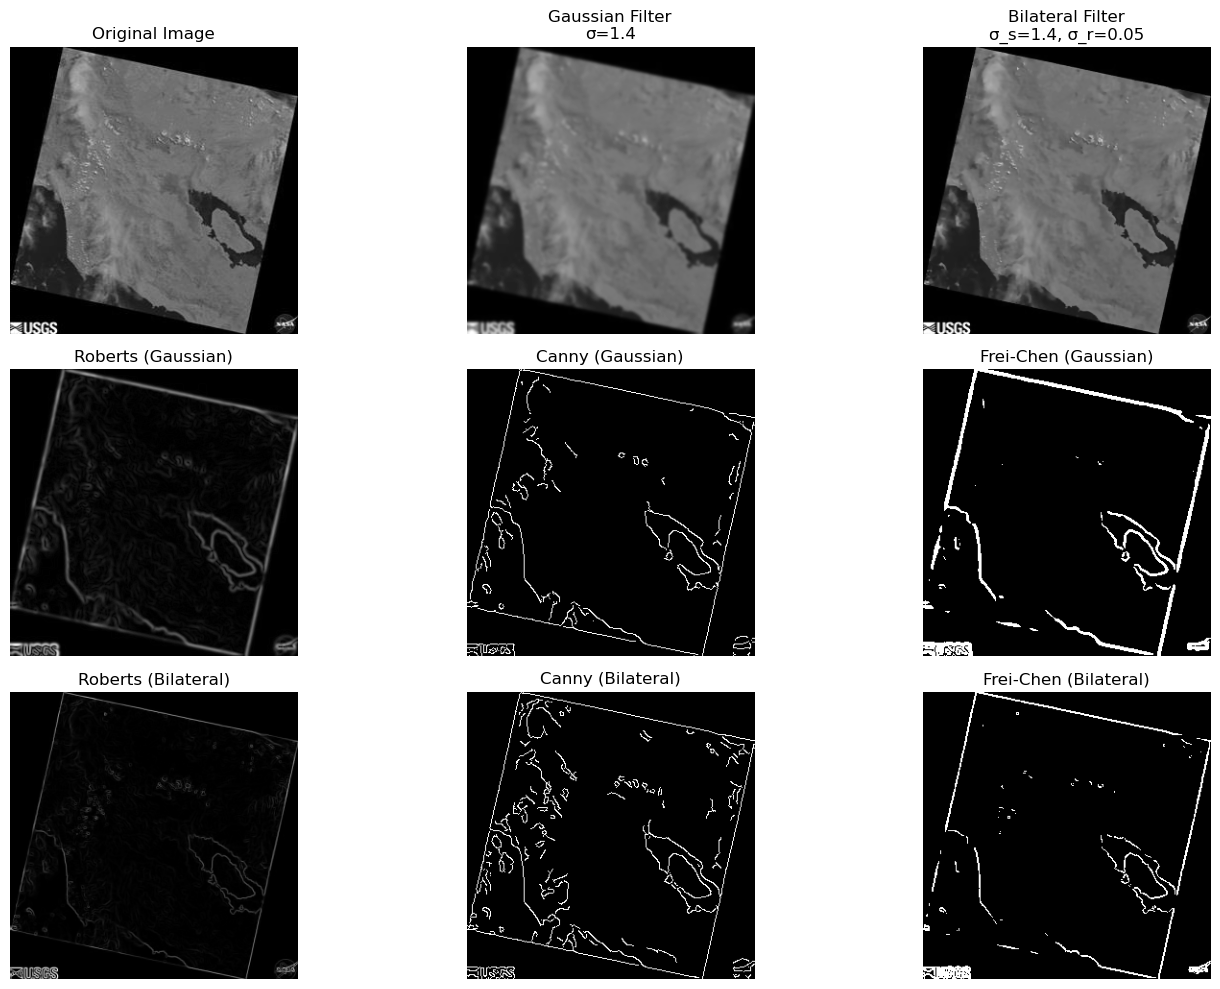

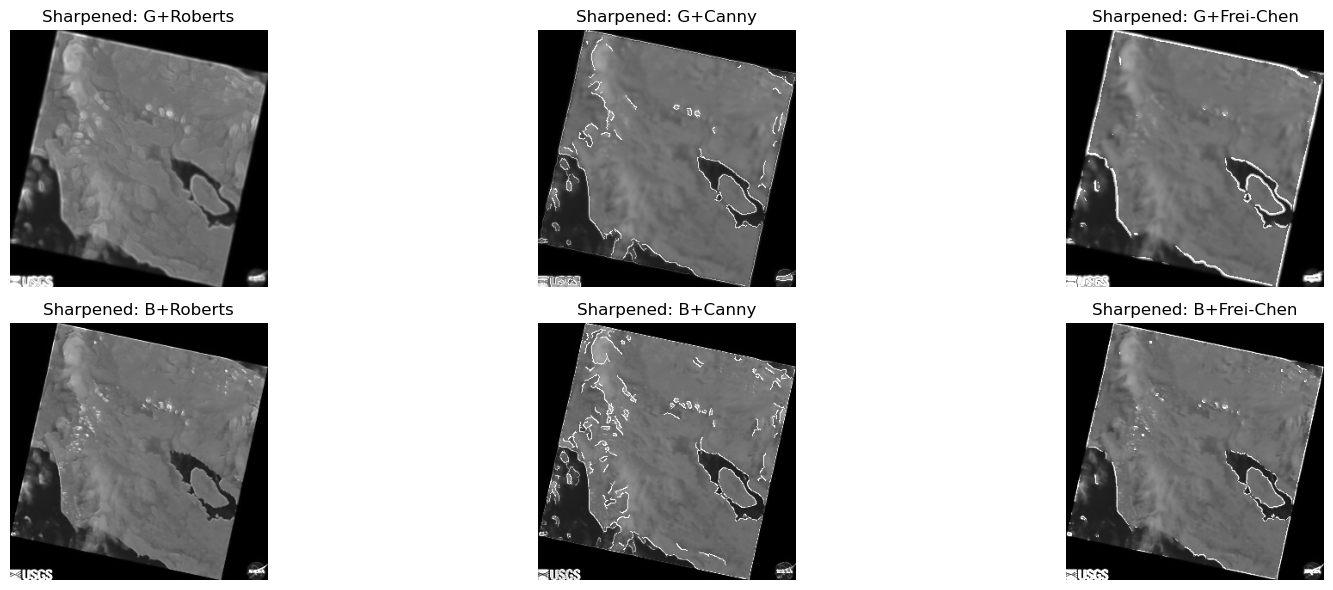


Evaluation Results:

Gaussian Filter:
Canny: MSE = 6648.4975, PSNR = 9.9036 dB, SSIM = 0.2508
Frei-Chen: MSE = 8981.3548, PSNR = 8.5974 dB, SSIM = 0.2091
Roberts: MSE = 9825.0875, PSNR = 8.2074 dB, SSIM = 0.1969

Bilateral Filter:
Canny: MSE = 7332.1615, PSNR = 9.4785 dB, SSIM = 0.2557
Frei-Chen: MSE = 9103.6415, PSNR = 8.5387 dB, SSIM = 0.2112
Roberts: MSE = 8922.6397, PSNR = 8.6259 dB, SSIM = 0.2095

Sharpened with Edges:
Sharpened image (Gaussian + Canny): MSE = 254.3877, PSNR = 24.0758 dB, SSIM = 0.8111
Sharpened image(Gaussian + Roberts): MSE = 642.8147, PSNR = 20.0499 dB, SSIM = 0.7417
Sharpened image(Gaussian + Frei-Chen): MSE = 907.6196, PSNR = 18.5518 dB, SSIM = 0.7794
Sharpened image(Bilateral + Canny: MSE = 85.1563, PSNR = 28.8286 dB, SSIM = 0.9340
Sharpened image(Bilateral + Roberts): MSE = 770.6293, PSNR = 19.2623 dB, SSIM = 0.7535
Sharpened image(Bilateral + Frei-Chen): MSE = 444.3217, PSNR = 21.6538 dB, SSIM = 0.8812


In [13]:

# Example usage 2
if __name__ == "__main__":
    #satellite image path
    image_path = "C:\\Users\\2001a\\Downloads\\DIP project\\11.jpg"

    # Parameters from the paper
    sigma_gaussian = 1.4  # Standard deviation for Gaussian filter
    sigma_s = 1.4         # Spatial parameter for Bilateral filter
    sigma_r = 0.05        # Range parameter for Bilateral filter

    results = process_image(image_path, sigma_gaussian, sigma_s, sigma_r)

    # Print evaluation results
    print("\nEvaluation Results:")
    for filter_type in results:
        print(f"\n{filter_type}:")
        for operator in results[filter_type]:
            mse, psnr,ssim = results[filter_type][operator]
            print(f"{operator}: MSE = {mse:.4f}, PSNR = {psnr:.4f} dB, SSIM = {ssim:.4f}")

In [31]:
# def apply_gaussian_filter(image, sigma):

#     # Calculate kernel size (odd and at least 3x3)
#     ksize = int(6 * sigma + 1)
#     if ksize % 2 == 0:
#         ksize += 1
#     print(ksize)
#     # Create 2D Gaussian kernel
#     ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
#     print(ax)
#     xx, yy = np.meshgrid(ax, ax)
#     print(yy)
#     kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    
#     kernal= kernel / np.sum(kernel)  # Normalize the kernel
    
#     # kernel_2d = np.array([[1, 2, 1],
#     #                  [2, 4, 2],
#     #                  [1, 2, 1]], dtype=np.float32) / 16

#     # Apply filter using convolution
#     filtered = cv2.filter2D(image, -1, kernal)
#     print(filtered.size)
#     return filtered

# image = cv2.imread("C:\\Users\\2001a\\Downloads\\DIP project\\15.jpg", cv2.IMREAD_GRAYSCALE)

# # Apply the built-in bilateral filter with varying parameters
# sigma = 1  # Increase for more smoothing
# sigma_r = 0.1  # Increase for more intensity smoothing

# filtered_image = apply_gaussian_filter(image, sigma)


In [239]:

# def bilaterals_filter(image, sigma_s, sigma_r):
#     image = image.astype(np.float32)
#     ksize = int(6 * sigma_s + 1) | 1  # Ensure odd kernel size
#     half_ksize = ksize // 2

#     # Create spatial kernel
#     ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
#     x, y = np.meshgrid(ax, ax)
#     spatial_kernel = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

#     # Pad image to handle borders
#     padded = cv2.copyMakeBorder(image, half_ksize, half_ksize, half_ksize, half_ksize, cv2.BORDER_REFLECT)
#     filtered = np.zeros_like(image)
#     print(padded.size)
#     # Apply filter
#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             region = padded[i:i+ksize, j:j+ksize]
#             range_kernel = np.exp(-((region - image[i, j])**2) / (2 * sigma_r**2))
#             kernel = spatial_kernel * range_kernel
#             kernel /= kernel.sum()
#             filtered[i, j] = (region * kernel).sum()

#     return filtered.astype(np.uint8)
# image = cv2.imread("C:\\Users\\2001a\\Downloads\\DIP project\\15.jpg", cv2.IMREAD_GRAYSCALE)

# # Apply the built-in bilateral filter with varying parameters
# sigma_s = 1  # Increase for more smoothing
# sigma_r = 0.1  # Increase for more intensity smoothing

# filtered_image = bilaterals_filter(image, sigma_s,sigma_r)


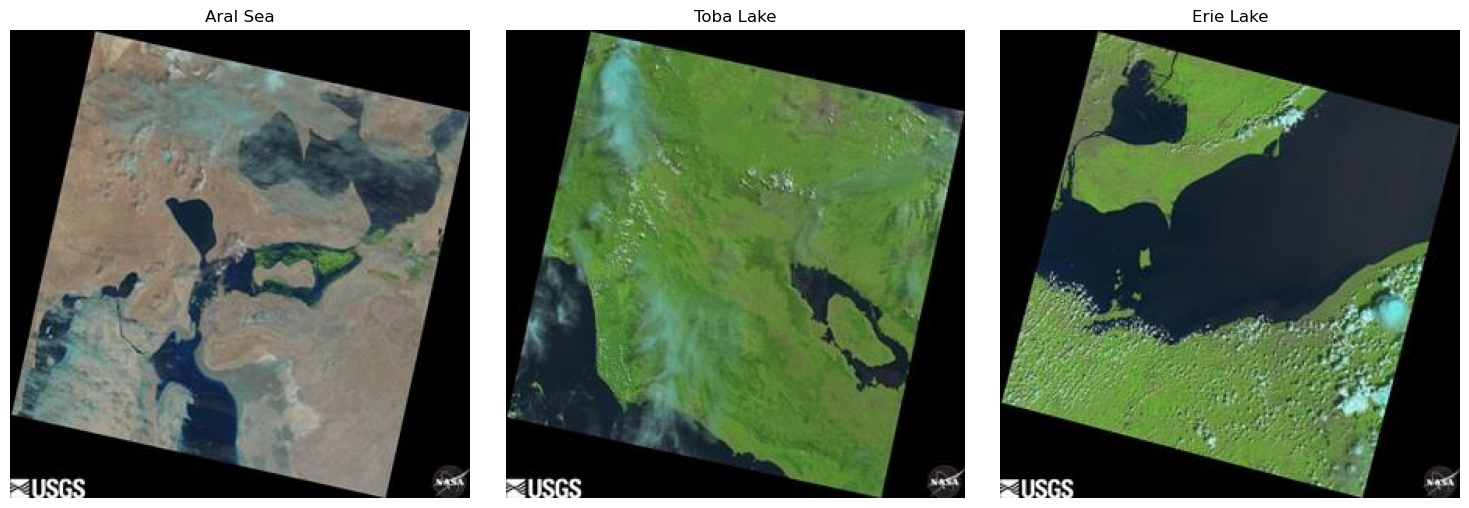

In [14]:
import matplotlib.pyplot as plt
import cv2

# Load images (replace with your image paths)
img1 = cv2.imread("C:\\Users\\2001a\\Downloads\\DIP project\\7.jpg")
img2 = cv2.imread("C:\\Users\\2001a\\Downloads\\DIP project\\11.jpg")
img3 = cv2.imread("C:\\Users\\2001a\\Downloads\\DIP project\\15.jpg")

# Convert from BGR (OpenCV format) to RGB (matplotlib format)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Plot images side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Aral Sea')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.title('Toba Lake')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.title('Erie Lake')
plt.axis('off')

plt.tight_layout()
plt.show()
